# Count RCM acquisitions
Example of downloading historical RCM acquisition data from canada.ca

In [25]:
%%capture
import sys
!{sys.executable} -m pip install httpx pandas geopandas beautifulsoup4

## Import dependencies

In [26]:
import httpx
import pandas as pd
import geopandas as gpd
from shapely import wkt
from bs4 import BeautifulSoup

## Url to fetch csv files

In [27]:
ftp_url = "https://ftp.maps.canada.ca/pub/csa_asc/Space-technology_Technologie-spatiale/radarsat_constellation_mission_plan/Archives/CSV/"

## Download RCM acquisition csv file locations

In [28]:
with httpx.Client(timeout=10) as client:
    response = client.get(ftp_url)
    response.raise_for_status()

In [29]:
soup = BeautifulSoup(response.read())

## These are the available csv files

In [30]:
hrefs = [item["href"] for item in soup.find_all("a", href=True) if item["href"].endswith(".csv")]
print(f"There are {len(hrefs)} acquisition datasets available.")
hrefs

There are 20 acquisition datasets available.


['2021-11_radarsat_constellation_mission.csv',
 '2021-12_radarsat_constellation_mission.csv',
 '2022-01_radarsat_constellation_mission.csv',
 '2022-02_radarsat_constellation_mission.csv',
 '2022-03_radarsat_constellation_mission.csv',
 '2022-04_radarsat_constellation_mission.csv',
 '2022-05_radarsat_constellation_mission.csv',
 '2022-06_radarsat_constellation_mission.csv',
 '2022-07_radarsat_constellation_mission.csv',
 '2022-08_radarsat_constellation_mission.csv',
 '2022-09_radarsat_constellation_mission.csv',
 '2022-10_radarsat_constellation_mission.csv',
 '2022-11_radarsat_constellation_mission.csv',
 '2022-12_radarsat_constellation_mission.csv',
 '2023-01_radarsat_constellation_mission.csv',
 '2023-02_radarsat_constellation_mission.csv',
 '2023-03_radarsat_constellation_mission.csv',
 '2023-04_radarsat_constellation_mission.csv',
 '2023-05_radarsat_constellation_mission.csv',
 '2023-06_radarsat_constellation_mission.csv']

## Geometry of Greenland
We want to filter only RCM aquisitions that intersect with Greenland's economic exclusion zone.

In [31]:
eez_url = "https://geo.vliz.be/geoserver/wfs?request=getfeature&service=wfs&version=1.1.0&typename=MarineRegions:eez&outputformat=json&filter=%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E8438%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E"
eez = gpd.read_file(eez_url)
eez = eez.to_crs(epsg=4326)
eez = eez.geometry.iloc[0]
eez

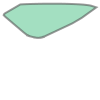

In [32]:
eez_simplified = eez.convex_hull
eez_simplified

In [33]:
greenland_land_url = "https://raw.githubusercontent.com/glynnbird/countriesgeojson/master/greenland.geojson"
greenland_land = gpd.read_file(greenland_land_url)
greenland_land = greenland_land.to_crs(epsg=4326)
greenland_land = greenland_land.geometry.iloc[0]
greenland_land

## Now, let's download all data frames from 2022

In [35]:
hrefs_2022 = [href for href in hrefs if href.startswith("2022")]
hrefs_2022

['2022-01_radarsat_constellation_mission.csv',
 '2022-02_radarsat_constellation_mission.csv',
 '2022-03_radarsat_constellation_mission.csv',
 '2022-04_radarsat_constellation_mission.csv',
 '2022-05_radarsat_constellation_mission.csv',
 '2022-06_radarsat_constellation_mission.csv',
 '2022-07_radarsat_constellation_mission.csv',
 '2022-08_radarsat_constellation_mission.csv',
 '2022-09_radarsat_constellation_mission.csv',
 '2022-10_radarsat_constellation_mission.csv',
 '2022-11_radarsat_constellation_mission.csv',
 '2022-12_radarsat_constellation_mission.csv']

In [36]:
data_frames = [pd.read_csv(f"{ftp_url}{href}") for href in hrefs_2022]

## Concatenate into a single DataFrame

In [37]:
data_frame = pd.concat(data_frames, ignore_index=True)

## Convert to a single GeoDataFrame

In [38]:
data_frame['geometry'] = data_frame.WKT.apply(wkt.loads)
data_frame.drop('WKT', axis=1, inplace=True)
geo_data_frame = gpd.GeoDataFrame(data_frame, geometry='geometry')

## Intersect with Canada

In [39]:
geo_data_frame_canada = geo_data_frame[geo_data_frame.intersects(eez_simplified)]
geo_data_frame_canada

SATID          BEAMTYPE_EN             BEAMTYPE_FR   BEAMID  \
10      RCM-1  Low Resolution 100m  Faible résolution 100m  SC100MA   
15      RCM-1  Low Resolution 100m  Faible résolution 100m  SC100MA   
18      RCM-1  Low Resolution 100m  Faible résolution 100m  SC100MA   
23      RCM-1  Low Resolution 100m  Faible résolution 100m  SC100MA   
24      RCM-1  Low Resolution 100m  Faible résolution 100m  SC100MA   
...       ...                  ...                     ...      ...   
203834  RCM-3    Quad-Polarization  Polarisation quadruple     QP14   
203838  RCM-3    Quad-Polarization  Polarisation quadruple     QP17   
203840  RCM-3    Quad-Polarization  Polarisation quadruple      QP7   
203857  RCM-3    Quad-Polarization  Polarisation quadruple     QP17   
203865  RCM-3    Quad-Polarization  Polarisation quadruple     QP11   

                        POLTYPE_EN                     POLTYPE_FR TXPOL RXPOL  \
10      Dual Co/Cross Polarization  Copolarisation double croisée     H   H+V   
15      Dual Co/Cross Polarization  Copolarisation double croisée     H   H+V   
18      Dual Co/Cross Polarization  Copolarisation double croisée     H   H+V   
23      Dual Co/Cross Polarization  Copolarisation double croisée     H   H+V   
24      Dual Co/Cross Polarization  Copolarisation double croisée     H   H+V   
...                            ...                            ...   ...   ...   
203834           Quad Polarization         Polarisation quadruple   H+V   H+V   
203838           Quad Polarization         Polarisation quadruple   H+V   H+V   
203840           Quad Polarization         Polarisation quadruple   H+V   H+V   
203857           Quad Polarization         Polarisation quadruple   H+V   H+V   
203865           Quad Polarization         Polarisation quadruple   H+V   H+V   

        CCD_EN CCD_FR  EXACTCCD_EN EXACTCCD_FR             UTC_STRT  \
10       False   FAUX        False        FAUX  2022-01-10T16:35:54   
15       False   FAUX        False        FAUX  2022-01-19T06:38:33   
18       False   FAUX        False        FAUX  2022-01-01T16:59:22   
23       False   FAUX        False        FAUX  2022-01-22T08:40:57   
24       False   FAUX        False        FAUX  2022-01-28T07:50:57   
...        ...    ...          ...         ...                  ...   
203834   False   FAUX        False        FAUX  2022-12-11T09:02:27   
203838   False   FAUX        False        FAUX  2022-12-23T09:02:27   
203840   False   FAUX        False        FAUX  2022-12-14T09:26:33   
203857   False   FAUX        False        FAUX  2022-12-22T08:54:26   
203865   False   FAUX        False        FAUX  2022-12-13T09:18:28   

                    UTC_END  PRODTYPE_EN   PRODTYPE_FR    BAQ  \
10      2022-01-10T16:36:22  GRD - 16bit  GRD - 16bits  3 bit   
15      2022-01-19T06:40:58  GRD - 16bit  GRD - 16bits  3 bit   
18      2022-01-01T16:59:32  GRD - 16bit  GRD - 16bits  3 bit   
23      2022-01-22T08:43:34  GRD - 16bit  GRD - 16bits  3 bit   
24      2022-01-28T07:51:49  GRD - 16bit  GRD - 16bits  3 bit   
...                     ...          ...           ...    ...   
203834  2022-12-11T09:02:40  SLC - 32bit  SLC - 32bits  3 bit   
203838  2022-12-23T09:02:37  SLC - 32bit  SLC - 32bits  3 bit   
203840  2022-12-14T09:26:37  SLC - 32bit  SLC - 32bits  3 bit   
203857  2022-12-22T08:54:38  SLC - 32bit  SLC - 32bits  3 bit   
203865  2022-12-13T09:18:36  SLC - 32bit  SLC - 32bits  3 bit   

                    RADARMD                                           geometry  
10                  ScanSAR  MULTIPOLYGON (((-18.92107 80.74036, -19.13801 ...  
15                  ScanSAR  MULTIPOLYGON (((11.32754 73.74260, 11.27491 73...  
18                  ScanSAR  MULTIPOLYGON (((-16.25210 78.67583, -16.33472 ...  
23                  ScanSAR  MULTIPOLYGON (((-25.68077 67.65428, -25.69677 ...  
24                  ScanSAR  MULTIPOLYGON (((-6.73107 73.77058, -6.79549 73...  
...                     ...                                   

In [45]:
geo_data_frame_eez = geo_data_frame_canada[~geo_data_frame_canada.within(greenland_land)]
geo_data_frame_eez

SATID          BEAMTYPE_EN             BEAMTYPE_FR   BEAMID  \
10      RCM-1  Low Resolution 100m  Faible résolution 100m  SC100MA   
15      RCM-1  Low Resolution 100m  Faible résolution 100m  SC100MA   
18      RCM-1  Low Resolution 100m  Faible résolution 100m  SC100MA   
23      RCM-1  Low Resolution 100m  Faible résolution 100m  SC100MA   
24      RCM-1  Low Resolution 100m  Faible résolution 100m  SC100MA   
...       ...                  ...                     ...      ...   
202830  RCM-3            Low Noise            Faible bruit    SCLNB   
202832  RCM-3            Low Noise            Faible bruit    SCLNB   
202833  RCM-3            Low Noise            Faible bruit    SCLNB   
202834  RCM-3            Low Noise            Faible bruit  SCLNCPC   
202836  RCM-3            Low Noise            Faible bruit    SCLNB   

                        POLTYPE_EN                     POLTYPE_FR TXPOL RXPOL  \
10      Dual Co/Cross Polarization  Copolarisation double croisée     H   H+V   
15      Dual Co/Cross Polarization  Copolarisation double croisée     H   H+V   
18      Dual Co/Cross Polarization  Copolarisation double croisée     H   H+V   
23      Dual Co/Cross Polarization  Copolarisation double croisée     H   H+V   
24      Dual Co/Cross Polarization  Copolarisation double croisée     H   H+V   
...                            ...                            ...   ...   ...   
202830  Dual Co/Cross Polarization  Copolarisation double croisée     H   H+V   
202832  Dual Co/Cross Polarization  Copolarisation double croisée     H   H+V   
202833  Dual Co/Cross Polarization  Copolarisation double croisée     H   H+V   
202834        Compact Polarization          Polarisation compacte     C   H+V   
202836  Dual Co/Cross Polarization  Copolarisation double croisée     H   H+V   

        CCD_EN CCD_FR  EXACTCCD_EN EXACTCCD_FR             UTC_STRT  \
10       False   FAUX        False        FAUX  2022-01-10T16:35:54   
15       False   FAUX        False        FAUX  2022-01-19T06:38:33   
18       False   FAUX        False        FAUX  2022-01-01T16:59:22   
23       False   FAUX        False        FAUX  2022-01-22T08:40:57   
24       False   FAUX        False        FAUX  2022-01-28T07:50:57   
...        ...    ...          ...         ...                  ...   
202830   False   FAUX        False        FAUX  2022-12-06T10:01:06   
202832   False   FAUX        False        FAUX  2022-12-17T17:49:45   
202833   False   FAUX        False        FAUX  2022-12-18T21:05:20   
202834   False   FAUX        False        FAUX  2022-12-12T15:33:57   
202836   False   FAUX        False        FAUX  2022-12-16T20:49:15   

                    UTC_END  PRODTYPE_EN   PRODTYPE_FR    BAQ  RADARMD  \
10      2022-01-10T16:36:22  GRD - 16bit  GRD - 16bits  3 bit  ScanSAR   
15      2022-01-19T06:40:58  GRD - 16bit  GRD - 16bits  3 bit  ScanSAR   
18      2022-01-01T16:59:32  GRD - 16bit  GRD - 16bits  3 bit  ScanSAR   
23      2022-01-22T08:43:34  GRD - 16bit  GRD - 16bits  3 bit  ScanSAR   
24      2022-01-28T07:51:49  GRD - 16bit  GRD - 16bits  3 bit  ScanSAR   
...                     ...          ...           ...    ...      ...   
202830  2022-12-06T10:01:20  GRD - 16bit  GRD - 16bits  3 bit  ScanSAR   
202832  2022-12-17T17:50:02  GRD - 16bit  GRD - 16bits  3 bit  ScanSAR   
202833  2022-12-18T21:05:34  GRD - 16bit  GRD - 16bits  3 bit  ScanSAR   
202834  2022-12-12T15:34:02  MLC - 16bit  MLC - 16bits  3 bit  ScanSAR   
202836  2022-12-16T20:50:07  GRD - 16bit  GRD - 16bits  3 bit  ScanSAR   

                                                 geometry  
10      MULTIPOLYGON (((-18.92107 80.74036, -19.13801 ...  
15      MULTIPOLYGON (((11.32754 73.74260, 11.27491 73...  
18      MULTIPOLYGON (((-16.25210 78.67583, -16.33472 ...  
23      MULTIPOLYGON (((-25.68077 67.65428, -25.69677 ...  
24      MULTIPOLYGON (((-6.73107 73.77058, -6.79549 73...  
...                                                   ...  
202830  MULTIPOLYGON

<AxesSubplot: >

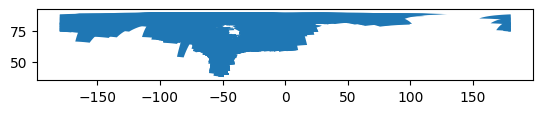

In [46]:
geo_data_frame_eez.plot()

## Summary statistics

In [47]:
summarize_columns = ['SATID', 'BEAMTYPE_EN', 'BEAMID', 'POLTYPE_EN', 'TXPOL', 'RXPOL', 'CCD_EN', 'EXACTCCD_EN', 'PRODTYPE_EN', 'BAQ', 'RADARMD']

for column in summarize_columns:
    print(column)
    print(geo_data_frame_eez[column].value_counts())
    print()

SATID
RCM-2    15446
RCM-1    15115
RCM-3    13955
Name: SATID, dtype: int64

BEAMTYPE_EN
Medium Resolution 50m    21735
Low Noise                18450
Low Resolution 100m       4174
Medium Resolution 16m       77
Medium Resolution 30m       76
High Resolution 5m           4
Name: BEAMTYPE_EN, dtype: int64

BEAMID
SCLNB      10788
SC50MB      7894
SC50MA      7395
SC50MC      4798
SC100MA     4174
SCLNC       3871
SCLNA       3257
SC50MD      1648
SCLND        277
SCLNCPC      137
SCLNCPB      120
SC30MB        53
SC30MC        22
16M17         13
16MCP17       12
16M16         10
16MCP2         8
16MCP10        6
16MCP8         5
16MCP13        4
16MCP14        4
16MCP4         3
16MCP16        2
16MCP6         2
16MCP15        2
16MCP12        2
16MCP7         2
5M14           2
16MCP11        1
SC30MD         1
16MCP5         1
5M1            1
5M10           1
Name: BEAMID, dtype: int64

POLTYPE_EN
Dual Co/Cross Polarization    44201
Compact Polarization            311
Single Polar